In [1]:
% matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd

In [2]:
gen_event_ = "ttbar-25"
outfile_ = "outfile-" + gen_event_ + ".root"
data_ = uproot.open(outfile_)["ntuples"]["tree"]
data_.keys()

['nevent',
 'nlumi',
 'nrun',
 'trackEta',
 'trackPhi',
 'qoverp',
 'dxy',
 'dsz',
 'trackPt',
 'trackTPIdx',
 'trackEtaError',
 'trackPhiError',
 'qoverpError',
 'dxyError',
 'dszError',
 'trackPtError',
 'trackParameters',
 'covarianceArray',
 'stereoHitX',
 'stereoHitY',
 'stereoHitZ',
 'stereoHitR',
 'stereoHitPhi',
 'stereoHitEta',
 'stereoHitLayer',
 'stereoTPIndex',
 'stereoHitMatch',
 'monoHitX',
 'monoHitY',
 'monoHitZ',
 'monoHitR',
 'monoHitPhi',
 'monoHitEta',
 'monoHitLayer',
 'monoTPIndex',
 'monoHitMatch',
 'simhit_x',
 'simhit_y',
 'simhit_z']

# Optimisation Tests

In [3]:
track_tp_idx_ = data_.array('trackTPIdx')
mono_tp_idx_ = data_.array('monoTPIndex')
stereo_tp_idx_ = data_.array('stereoTPIndex')

In [5]:
def list_to_set(input_array_):
    '''
    Format: 3-level nested lists - [[[...] ...] ...]
    '''
    output_array_ = []
    for index_ in range(len(input_array_)):
        output_array_.append([])
        for second_list_ in input_array_[index_]:
            output_array_[index_].append(set(second_list_))
    return output_array_

In [6]:
%%time 
mono_tp_idx_set_ = list_to_set(mono_tp_idx_)

CPU times: user 982 ms, sys: 16.3 ms, total: 998 ms
Wall time: 1.01 s


In [7]:
%%time
track_tp_idx_ = data_.array('trackTPIdx')
mono_tp_idx_ = data_.array('monoTPIndex')
len(track_tp_idx_)

#track_tp_match_map_ = {}

for event_ in range(len(track_tp_idx_)):
    for tp_list_ in track_tp_idx_[event_]:
        if len(tp_list_) > 1:
            print event_, "has a track with multiple TP matches"
        for mono_tp_list_ in mono_tp_idx_set_[event_]:
            if tp_list_[0] in mono_tp_list_:
                continue

CPU times: user 700 ms, sys: 3.21 ms, total: 703 ms
Wall time: 706 ms


In [8]:
'''
Checking if each item in the lists is converted to the set
%%time
for i in range(25):
    for j in range(len(mono_tp_idx_[i])):
        for x in mono_tp_idx_[i][j]:
            if x not in mono_tp_idx_set_[i][j]:
                print 'Problem', i, j
'''

"\nChecking if each item in the lists is converted to the set\n%%time\nfor i in range(25):\n    for j in range(len(mono_tp_idx_[i])):\n        for x in mono_tp_idx_[i][j]:\n            if x not in mono_tp_idx_set_[i][j]:\n                print 'Problem', i, j\n"

# Preprocessing 1: Reformat List of Indices to Sets of Indices for each Rechit

In [9]:
# Convert all tracking particle index lists to sets for faster search

mono_tp_idx_set_ = list_to_set(data_.array('monoTPIndex'))
stereo_tp_idx_set_ = list_to_set(data_.array('stereoTPIndex'))
track_tp_idx_set_ = list_to_set(data_.array('trackTPIdx'))

# Preprocessing 2: Add all data into dataframes

In [10]:
import pandas as pd
from pandas import DataFrame as df
from collections import OrderedDict

In [11]:

'''
Dataframe column titles and datatypes

:event_id: int
:rechit_id: int
:track_id: int
:rechit_ids: list(int)
:track_ids: list(int)
:matched/unmatched_track_tp_index: set(int)  # iterating over sets has lower complexity
:rechit_tp_index: set(int)  # iterating over sets has lower complexity
:match_count: int  # count the number of rechits/tracks matched to the track/rechit
''' 

'\nDataframe column titles and datatypes\n\n:event_id: int\n:rechit_id: int\n:track_id: int\n:rechit_ids: list(int)\n:track_ids: list(int)\n:matched/unmatched_track_tp_index: set(int)  # iterating over sets has lower complexity\n:rechit_tp_index: set(int)  # iterating over sets has lower complexity\n'

In [31]:
%%time
'''
Adding stereo and mono rechit data into a global dataframe

:stereo/mono_tp_index_: event-based list of rechit-based list of sets of int (tp_index)

'''
def create_global_rechit_df(stereo_tp_idx_, mono_tp_idx_, ):
    rechit_global_map_ = OrderedDict({"event_id": [], "rechit_id": [], "rechit_tp_index": []})
    global_counter_ = 0
    
    if len(stereo_tp_idx_) != len(stereo_tp_idx_):
        raise ValueError('Rechit arrays represent differing event lengths [stereo, mono]:', len(stereo_tp_idx_), len(mono_tp_idx_))
    
    for event_id_ in range(len(stereo_tp_idx_)):
        # Count the number of rechits in that event
        event_rechit_count_ = len(stereo_tp_idx_[event_id_]) + len(mono_tp_idx_[event_id_])

        rechit_global_map_["event_id"].extend([event_id_] * event_rechit_count_)
        rechit_global_map_["rechit_id"].extend(range(global_counter_, global_counter_ + event_rechit_count_))     
        rechit_global_map_["rechit_tp_index"].extend(stereo_tp_idx_[event_id_])
        rechit_global_map_["rechit_tp_index"].extend(mono_tp_idx_[event_id_])
        global_counter_ += event_rechit_count_
        
        # TODO: Extend the dataframe with additional parameters
        
        
    # Convert dict to dataframe
    rechit_global_df_ = df.from_dict(rechit_global_map_)
    return rechit_global_df_
    
# Check Memory Usage of DataFrame
# print rechit_global_df_.memory_usage(deep=True)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [34]:
%%time
rechit_global_df_ = create_global_rechit_df(stereo_tp_idx_, mono_tp_idx_)
print rechit_global_df_.head(10)

   event_id rechit_tp_index  rechit_id
0         0           [172]          0
1         0           [246]          1
2         0           [246]          2
3         0           [115]          3
4         0           [144]          4
5         0           [587]          5
6         0           [171]          6
7         0           [144]          7
8         0          [1016]          8
9         0          [1025]          9
CPU times: user 2.63 s, sys: 30.5 ms, total: 2.66 s
Wall time: 2.67 s


In [13]:
#%%time

'''
Check if/where multiple tracking particle indices occur in the rechits
This is to verify the data stored in the dict is ordered correctly
'''
'''
global_counter_ = 0

for i in range(len(stereo_tp_idx_)):
    for j in range(len(stereo_tp_idx_[i])):
        
        # If multiple matches are found in the rechits
        if len(stereo_tp_idx_[i][j]) > 1:
            print "Multiple Matches found at event", i, "rechit", j
            if rechit_global_map_["unmatched_track_tp_index"][global_counter_] == stereo_tp_idx_[i][j]:
                continue
            else:
                print "Rechit TP Index is not being stored completely/correctly in the global map"
        global_counter_ += 1
'''

'\nglobal_counter_ = 0\n\nfor i in range(len(stereo_tp_idx_)):\n    for j in range(len(stereo_tp_idx_[i])):\n        \n        # If multiple matches are found in the rechits\n        if len(stereo_tp_idx_[i][j]) > 1:\n            print "Multiple Matches found at event", i, "rechit", j\n            if rechit_global_map_["unmatched_track_tp_index"][global_counter_] == stereo_tp_idx_[i][j]:\n                continue\n            else:\n                print "Unmatched Track TP Index is not being stored completely/correctly in the map"\n        global_counter_ += 1\n'

## Match the Tracks to Rechits in a Global Array of Tracks

In [93]:
%%time

# Define the dictionaries to be cast into dataframes
track_to_rechit_map_ = OrderedDict({"event_id": [], "track_id": [], "track_tp_index": [], "rechit_ids": [], "match_count": []})

# Future Requirement?
rechit_to_track_map_ = OrderedDict({"event_id": [], "rechit_id": [], "rechit_tp_index": [], "track_ids": [], "match_count": []})

# Initialize the Global Track ID
global_track_id_ = 0

print len(track_tp_idx_)
for event_id_ in range(len(track_tp_idx_)):
    
    num_tracks_in_event_ = len(track_tp_idx_[event_id_])

    # Add track data to the dict in an efficient manner
    track_to_rechit_map_["event_id"].extend([event_id_] * num_tracks_in_event_)
    # print global_track_id_, num_tracks_in_event_
    
    track_to_rechit_map_["track_id"].extend(range(global_track_id_, global_track_id_ + num_tracks_in_event_))
    track_to_rechit_map_["track_tp_index"].extend(track_tp_idx_[event_id_])
    
    # Append multiple empty lists in place of the values not filled yet
    track_to_rechit_map_["match_count"].extend([] for _ in range(num_tracks_in_event_))
    track_to_rechit_map_["rechit_ids"].extend([] for _ in range(num_tracks_in_event_))
    
    # Retrieve the subset of the global rechit dataframe for this event_id
    event_df_ = rechit_global_df_[rechit_global_df_['event_id']==event_id_]
    
    # Check the TPs matched to tracks and find rechits for each TP (Stereo and Mono)
    for track_tp_list_ in track_tp_idx_[event_id_]:
        rechit_matches_ = []
        
        if len(track_tp_list_) <= 1:
        
            # Iterate over the index and values of each rechit tp index list
            for idx_, tp_idx_list_ in event_df_['rechit_tp_index'].items():
                # Find the match for the first tp index in the track tp list
                if track_tp_list_[0] in tp_idx_list_:
                    rechit_matches_.append(event_df_['rechit_id'][idx_])

            track_to_rechit_map_["match_count"][global_track_id_] = len(rechit_matches_)
            track_to_rechit_map_["rechit_ids"][global_track_id_] = set(rechit_matches_)
        
        # If track has multiple tp indices, pick the one with the most hits

        # Note: This approach fails if the tp index with more rechit matches has more 
        # 'common' hits with other tracks and is later discarded due to the common hits 
        # belonging to other tracks
        if len(track_tp_list_) > 1:
            rechit_matches_array_ = []
            match_count_array_ = []
            
            print "Found multiple TP indices in event", event_id_, "for global track", 
            print global_track_id_, track_tp_list_
            
            for track_idx_ in track_tp_list_:
                rechit_matches_ = []
                
                # Iterate over the index and values of each rechit tp index list
                for idx_, tp_idx_list_ in event_df_['rechit_tp_index'].items():
                    rechit_matches_.append(event_df_['rechit_id'][idx_])

                rechit_matches_array_.append(rechit_matches_)
                match_count_array_.append(len(rechit_matches_))
            
            # Store the global rechit ids and count of matches in a temporary list
            for key, value in zip(match_count_array_, rechit_matches_array_):
                tmp_dict_.append((key, value))
            
            # Pick the largest number of matches and corresponding global rechit ids
            tmp_dict_ = sorted(tmp_dict_, reverse=True)
            track_to_rechit_map_["match_count"][global_track_id_] = tmp_dict_[0][0]
            track_to_rechit_map_["rechit_ids"][global_track_id_] = tmp_dict_[0][1]

        # Check duplicates
        if len(set(rechit_matches_)) < len(rechit_matches_):
            raise ValueError('rechit_matches_ has duplicate values: Some Rechits are being matched twice!')
        
        # Increment the Global Track ID
        global_track_id_ += 1

25
CPU times: user 2.51 s, sys: 30.3 ms, total: 2.54 s
Wall time: 2.59 s


In [94]:
for key in track_to_rechit_map_.keys():
    print key, ":", len(track_to_rechit_map_[key])

#track_to_rechit_df_ = df.from_dict(track_to_rechit_map_)

event_id : 1627
match_count : 1627
track_tp_index : 1627
rechit_ids : 1627
track_id : 1627


In [95]:
track_to_rechit_df_ = df.from_dict(track_to_rechit_map_)
track_to_rechit_df_.head(10)


,event_id,match_count,track_tp_index,rechit_ids,track_id
0,0,13,[192],"{738, 3748, 2655, 3750, 236, 3629, 3749, 3284,...",0
1,0,16,[157],"{2304, 6161, 839, 840, 2601, 5870, 1041, 275, ...",1
2,0,15,[124],"{3712, 2627, 836, 2603, 1038, 3863, 3377, 3797...",2
3,0,20,[22],"{2560, 2656, 3874, 739, 740, 3745, 4046, 3625,...",3
4,0,21,[3],"{1891, 612, 6065, 2985, 5771, 6220, 525, 526, ...",4
5,0,85,[48],"{1921, 1515, 3460, 2951, 2905, 397, 6159, 6157...",5
6,0,16,[196],"{4064, 4130, 2915, 4068, 2824, 2794, 332, 1071...",6
7,0,18,[46],"{354, 4547, 5397, 1334, 1223, 2953, 4746, 4726...",7
8,0,19,[45],"{1344, 4720, 5393, 4938, 2955, 1229, 4719, 399...",8
9,0,0,[-2],{},9


# Generate Plots

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#fig_ = plt.figure()
#ax_ = Axes3D(fig_)

In [ ]:
# Find Number of Events based on any property length
track_eta_ = data_.array("trackEta")
print "Number of Events: ", len(track_eta_)

# Track Parameters

In [ ]:
# Iterate over 5 track parameters and plot their distribution
# Note: THIS IS LOG SCALE

for key in ["trackEta", "trackPhi", "qoverp", "dxy", "dsz"]:
    track_param_ = data_.array(key)
    concat_track_param_ = []
    
    for param_val_ in track_param_:
        concat_track_param_.extend(param_val_)
    print "Iterating over", key, "from", len(concat_track_param_), "tracks"
    
    plt.clf()
    ax_ = plt.subplot()
    ax_.hist(concat_track_param_, histtype='stepfilled', bins=100, orientation='vertical')
    plt.grid(True)
    plt.ylabel('Frequency')
    
    # Comment the next line for a linear scale
    plt.yscale('log')
    
    plt.xlabel('Distribution of ' + key)
    plt.title(key + ' Distribution')
    plt.savefig('plots/' + gen_event_ + '/track/' + key)
    plt.show()

In [ ]:
# Additional visualization discarding high-pt events for more clarity

track_pt_ = data_.array('trackPt')
concat_track_pt_ = []
high_pt_events_ = {}

for event_ in range(len(track_pt_)):
    for trk_pt_val_ in track_pt_[event_]:
        
        # What is a reasonable general threshold for Track Pt?
        if trk_pt_val_ < 30:
            concat_track_pt_.append(trk_pt_val_)
        else:
            if event_ in high_pt_events_:
                high_pt_events_[event_] += 1
            else:
                high_pt_events_[event_] = 1
            concat_track_pt_.append(30)
            
print "Iterating over track pt from", len(concat_track_pt_), "tracks"

plt.clf()
ax_ = plt.subplot()
ax_.hist(concat_track_pt_, histtype='stepfilled', bins=100, orientation='vertical')
plt.grid(True)
plt.ylabel('Frequency')
plt.yscale('log')
plt.xlabel('Distribution of Track Pt')
plt.title('Track Pt Distribution')
plt.savefig('plots/' + gen_event_ + '/track/track-pt')
plt.show()

# Events with high pt tracks and their distribution

plt.clf()
ax_ = plt.subplot()
ax_.hist(high_pt_events_.keys(), weights=high_pt_events_.values(), bins=100, orientation='vertical')
plt.grid(True)
plt.ylabel('Number of Tracks')
plt.yscale('log')
plt.xlabel('Event Number')
plt.title('Distribution of High Pt Tracks')
plt.savefig('plots/' + gen_event_ + '/track/high-pt-events')
plt.show()


In [ ]:
# Input the range of values with odd track phi in case it is a specific part

# Note: This is ONLY useful if there is a 'sub-portion' of the graph that is weird-looking
# If it is oddly distributed throughout, an alternative means of visualization is needed

track_phi_ = data_.array('trackPhi')
concat_track_phi_ = []
anomalous_phi_event_number_ = {}
for event_ in range(len(track_phi_)):
    
    for phi_idx_ in range(len(track_phi_[event_])):
        
        if (track_phi_[event_][phi_idx_] >= -0.8) and (track_phi_[event_][phi_idx_] <= 2):
            if event_ in anomalous_phi_event_number_:
                anomalous_phi_event_number_[event_] += 1
            else:
                anomalous_phi_event_number_[event_] = 1
            continue
        else:    
            concat_track_phi_.append(track_phi_[event_][phi_idx_])
        
print len(concat_track_phi_)
ax_ = plt.subplot()
ax_.hist(concat_track_phi_, histtype='stepfilled', bins=100, orientation='vertical')
plt.grid(True)
plt.ylabel('Frequency')
plt.xlabel('Distribution of Track Phi')
plt.title('Weird Track Phi Distribution')
plt.show()

In [ ]:
# Plot histogram of events with oddly distributed track phi
print anomalous_phi_event_number_
odd_phi_count_ = anomalous_phi_event_number_.values()
x_index_ = range(len(odd_phi_count_))
# print anomalous_phi_event_number_
ax_ = plt.subplot()
ax_.hist(x_index_, weights=odd_phi_count_, bins=100, orientation='vertical')
plt.grid(True)
plt.ylabel('Frequency of Odd Phi')
plt.xlabel('Event Numbers')
plt.title('Odd Track Phi Distribution across Events')
plt.show()

In [ ]:
# Plot the distribution of tracks in events 
# using the length of any paramater array - e.g. track eta

track_Eta_ = data_.array("trackEta")
concat_num_tracks_ = []

for i in range(len(track_Eta_)):
     concat_num_tracks_.append(len(track_Eta_[i]))
print "Added", sum(concat_num_tracks_), "tracks from", len(concat_num_tracks_), "events"
ax_ = plt.subplot()
ax_.hist(concat_num_tracks_, histtype='bar', bins=80, align='mid', orientation='vertical')

plt.xlabel('No. of Tracks')
plt.ylabel('No. of Events')
plt.title('Tracks vs. Events Distribution')
plt.grid(True)
plt.savefig('plots/' + gen_event_ + '/track/event-track-distribution')
plt.show()

In [ ]:
# TODO: Look at whether the same/similar event is getting replicated multiple times

# Plot SimHit Distribution in X and Y Axes

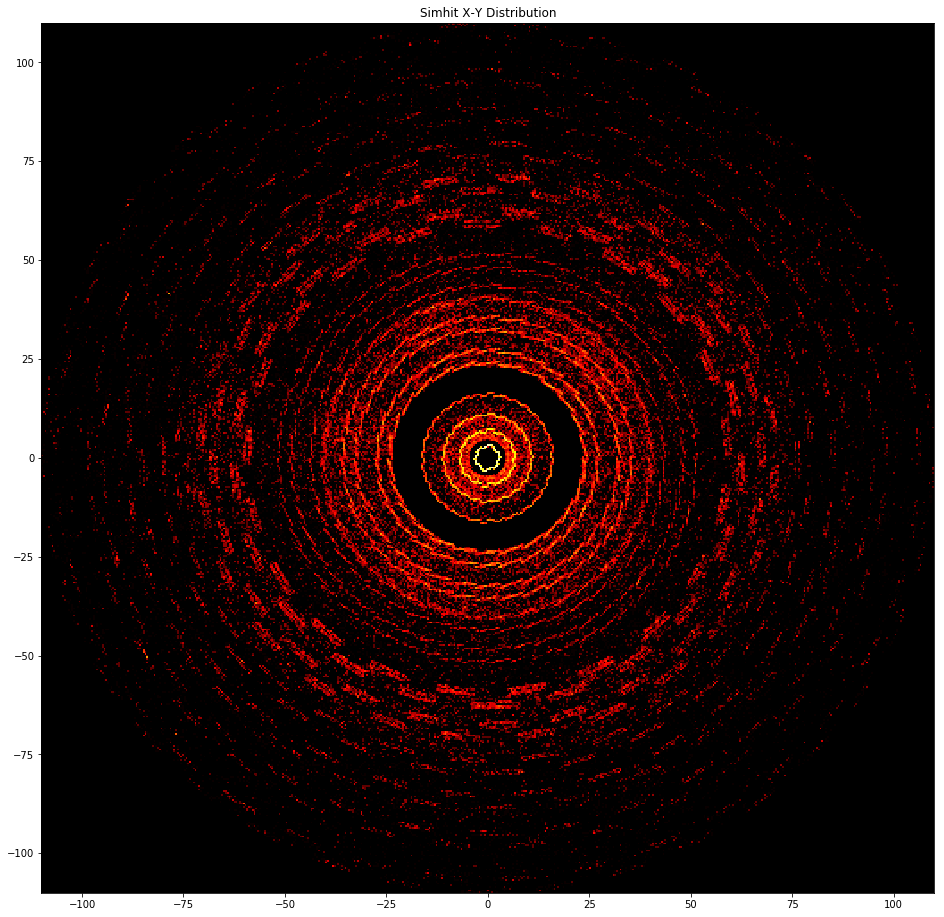

In [46]:
simhit_x_ = data_.array('simhit_x')
simhit_y_ = data_.array('simhit_y')
simhit_z_ = data_.array('simhit_z')

# Append all simhits into a single array for plotting
if len(simhit_x_) == len(simhit_y_):
    concat_simhit_x_ = []
    concat_simhit_y_ = []

    for i in range(len(simhit_x_)):
        concat_simhit_x_.extend(simhit_x_[i])
        concat_simhit_y_.extend(simhit_y_[i])

plt.figure(figsize=(16, 16))
ax_ = plt.subplot(1,1,1)
# Plot the 2D Histogram for Simhits
plt.title('Simhit X-Y Distribution')
ax_.patch.set_facecolor('black')
plt.hist2d(concat_simhit_x_, concat_simhit_y_, bins=500, norm=matplotlib.colors.LogNorm(), cmap='hot')
plt.savefig('plots/' + gen_event_ + '/sim/hitdistribution')
plt.show()

<IPython.core.display.Javascript object>


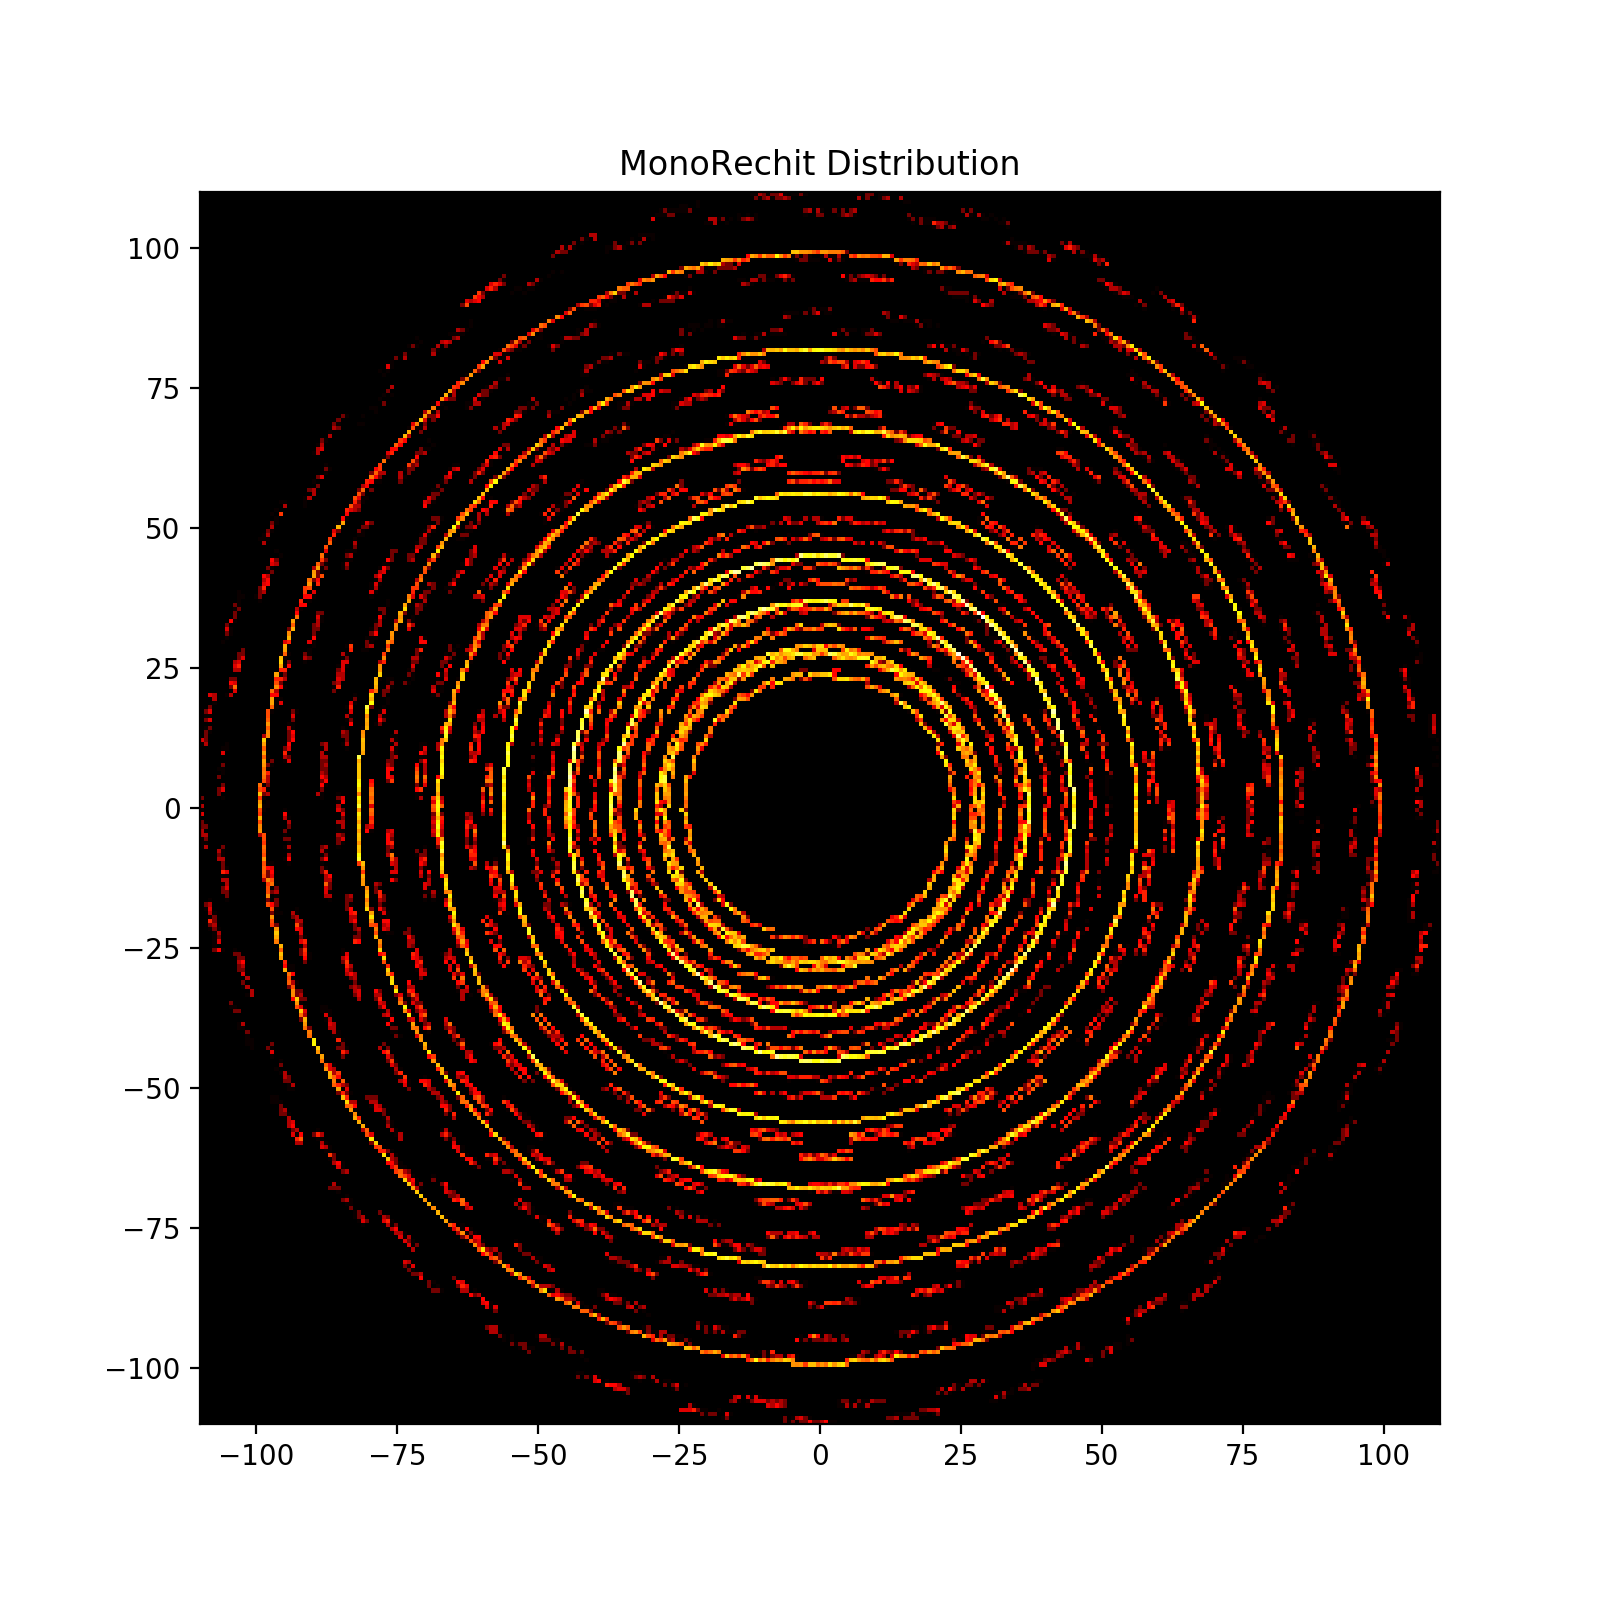

In [35]:
# ToDo: Add lognorm colormap

mono_x_ = data_.array("monoHitX") 
mono_y_ = data_.array("monoHitY")
mono_z_ = data_.array("monoHitZ")

# Append all mono rehits into a single array for plotting
if len(mono_x_) == len(mono_y_):
    concat_mono_x_ = []
    concat_mono_y_ = []

    for i in range(len(mono_x_)):
        concat_mono_x_.extend(mono_x_[i])
        concat_mono_y_.extend(mono_y_[i])

plt.figure(figsize=(8,8))
ax_ = plt.subplot(1,1,1)
# Plot the 2D Histogram for Mono Rechits
plt.title('MonoRechit Distribution')
ax_.patch.set_facecolor('black')
plt.hist2d(concat_mono_x_, concat_mono_y_, bins=300, norm=matplotlib.colors.LogNorm(), cmap='hot')
plt.savefig('plots/' + gen_event_ + '/stereo/rechitdistribution')
plt.show()

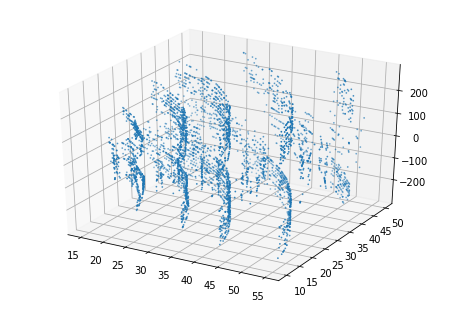

In [50]:
# Trying to explore the hole in 3 dimensions
# Not quite possible to do manually?
%matplotlib inline
fig_ = plt.figure()
ax_ = Axes3D(fig_)
concat_mono_x_ = []
concat_mono_y_ = []
concat_mono_z_ = []

for event_ in range(10):
    for x, y, z, in zip(mono_x_[event_], mono_y_[event_], mono_z_[event_]):
        if x < 55 and x > 15 and y > 10 and y < 50:
            concat_mono_x_.append(x)
            concat_mono_y_.append(y)
            concat_mono_z_.append(z)   

ax_.scatter3D(concat_mono_x_, concat_mono_y_, concat_mono_z_, s=0.6)

<IPython.core.display.Javascript object>


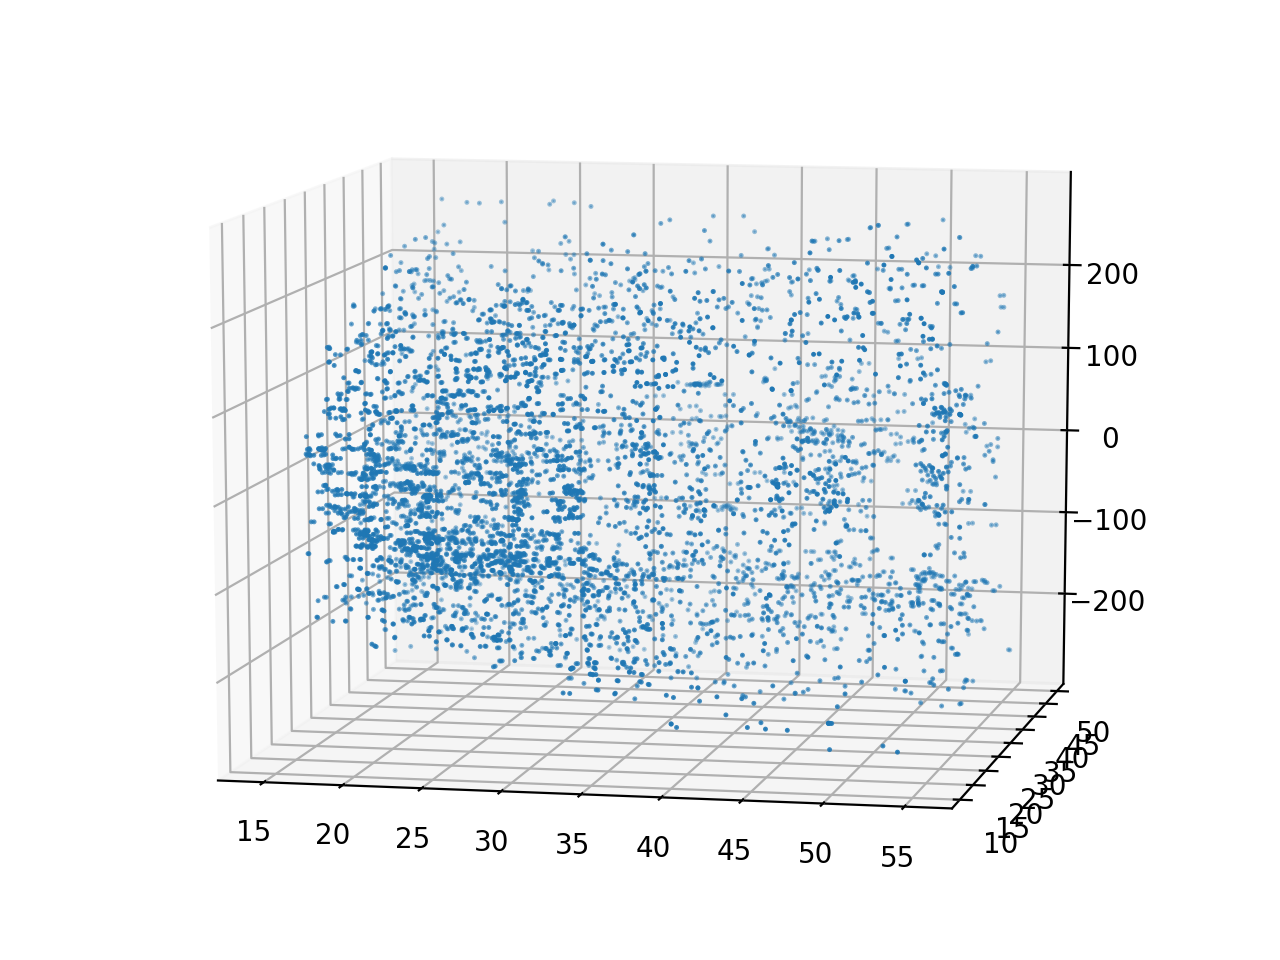

In [49]:
# Trying to explore the hole in 3 dimensions
# Not quite possible to do manually?

% matplotlib notebook
fig_ = plt.figure()
ax_ = Axes3D(fig_)

concat_simhit_x_ = []
concat_simhit_y_ = []
concat_simhit_z_ = []

for event_ in range(10):
    for x, y, z, in zip(simhit_x_[event_], simhit_y_[event_], simhit_z_[event_]):
        if x < 55 and x > 15 and y > 10 and y < 50:
            concat_simhit_x_.append(x)
            concat_simhit_y_.append(y)
            concat_simhit_z_.append(z)   

ax_.scatter3D(concat_simhit_x_, concat_simhit_y_, concat_simhit_z_, s=0.6)

<Figure size 432x288 with 0 Axes>

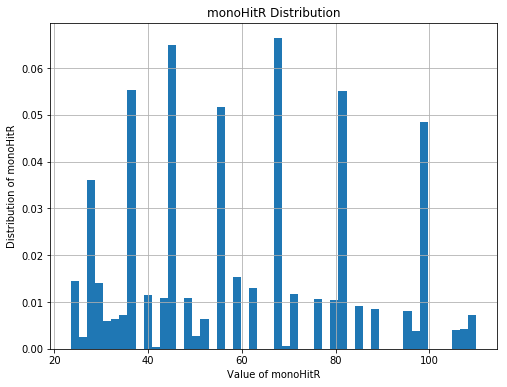

<Figure size 432x288 with 0 Axes>

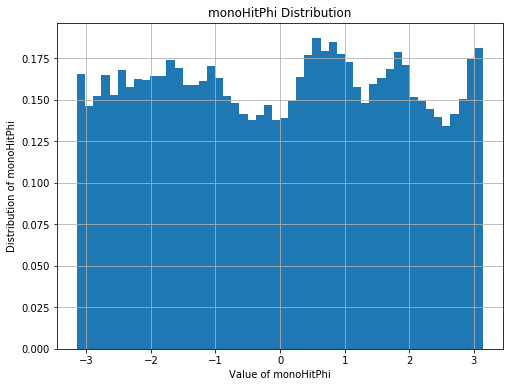

<Figure size 432x288 with 0 Axes>

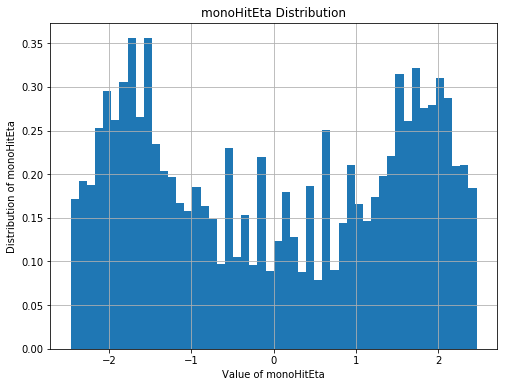

In [42]:
# Define a loop that plots R, Phi, and Eta for Mono Hits
%matplotlib inline
position_ = 1
for param in ["monoHitR", "monoHitPhi", "monoHitEta"]:
    mono_param_ = data_.array(param)
    concat_mono_param_ = []
    
    for i in range(len(mono_param_)):
            concat_mono_param_.extend(mono_param_[i])

    plt.clf()
    fig, ax_ = plt.subplots(figsize=(8, 6))
    position_ += 1
    # Plot the 2D Histogram for Mono Rechits
    ax_.set_title('MonoRechit Distribution of ' + param)
    ax_.hist(concat_mono_param_, bins=50, histtype='stepfilled', align='mid', orientation='vertical', density=True)
    plt.xlabel('Value of ' + param)
    plt.ylabel('Distribution of ' + param)
    plt.title(param + ' Distribution')
    plt.grid(True)
    plt.savefig('plots/' + gen_event_ + '/mono/' + param)
    plt.show()

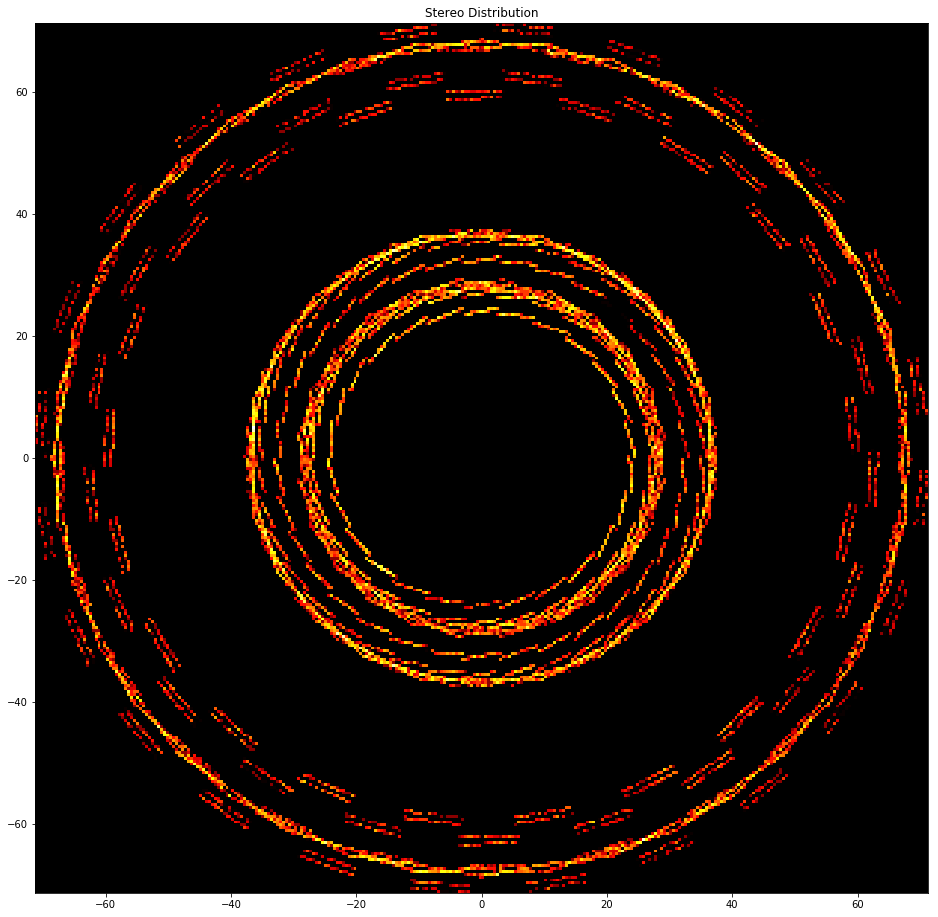

In [44]:
# ToDo: Add lognorm colormap

stereo_x_ = data_.array("stereoHitX") 
stereo_y_ = data_.array("stereoHitY")
stereo_z_ = data_.array("stereoHitZ")

if len(mono_x_) == len(mono_y_):
    concat_stereo_x_ = []
    concat_stereo_y_ = []

    for i in range(len(mono_x_)):
        concat_stereo_x_.extend(stereo_x_[i])
        concat_stereo_y_.extend(stereo_y_[i])

plt.figure(figsize=(16,16))
ax_ = plt.subplot(1,1,1)
# Plot the 2D Histogram for Mono Rechits
ax_.set_title('Stereo Distribution')
ax_.patch.set_facecolor('black')
ax_.hist2d(concat_stereo_x_, concat_stereo_y_, bins=300, norm=matplotlib.colors.LogNorm(), cmap='hot')
plt.savefig('plots/' + gen_event_ + '/stereo/rechitdistribution')
plt.show()

In [ ]:
# Define a loop that plots R, Phi, and Eta for Stereo Hits

for param in ["stereoHitR", "stereoHitPhi", "stereoHitEta"]:
    stereo_param_ = data_.array(param)
    concat_stereo_param_ = []
    
    for i in range(len(mono_param_)):
            concat_stereo_param_.extend(stereo_param_[i])

    plt.clf()
    fig, ax_ = plt.subplots(figsize=(8, 6))
    position_ += 1
    # Plot the 2D Histogram for Mono Rechits
    ax_.set_title('StereoRechit Distribution of ' + param)
    ax_.hist(concat_stereo_param_, bins=50, histtype='stepfilled', align='mid', orientation='vertical', density=True)
    plt.xlabel('Value of ' + param)
    plt.ylabel('Distribution of ' + param)
    plt.title(param + ' Distribution')
    plt.grid(True)
    plt.savefig('plots/' + gen_event_ + '/stereo/' + param)
    plt.show()

In [ ]:
stereo_tp_idx_ = data_.array('stereoTPIndex')
mono_tp_idx_ = data_.array('monoTPIndex')
track_tp_idx_ = data_.array('trackTPIdx')

# Check that both have been generated for the same number of events
# Just for clarity
print len(track_tp_idx_) == len(stereo_tp_idx_),
print len(track_tp_idx_) == len(mono_tp_idx_),
print "\nTotal", len(track_tp_idx_), "events"

In [ ]:
# Check if any tracks map to multiple tracking particles
for i in range(len(track_tp_idx_)):
    for track_tp_list_ in track_tp_idx_[i]:
        if len(track_tp_list_) > 1:
            print "Track maps to multiple TPs in event", i

In [ ]:
# Check if any hits map to multiple tracking particles
# It is NOT NECESSARY that these TPs map to actual tracks
%%time
hit_tp_count_ = {}

# Iterate over event length in mono and stereo rechits
for event_ in range(len(stereo_tp_idx_)):
    for stereo_tp_list_ in stereo_tp_idx_[event_]:
        tp_len_ = len(stereo_tp_list_)
        # Add to a dictionary of <num of TP matches : hit count>
        if tp_len_ in hit_tp_count_:
            hit_tp_count_[tp_len_] += 1
        else:
            hit_tp_count_[tp_len_] = 1
    
    for mono_tp_list_ in mono_tp_idx_[event_]:
        tp_len_ = len(mono_tp_list_)
        # Add to a dictionary of <num of TP matches : hit count>
        if tp_len_ in hit_tp_count_:
            hit_tp_count_[tp_len_] += 1
        else:
            hit_tp_count_[tp_len_] = 1

# This prints how many hits map to multiple matches
# <num matches to TPs: ncount of hits>
print "Number of matches and number of hits with those many TP matches\n", hit_tp_count_

In [ ]:
# NEEDS OPTIMIZATION - RUNS FOREVER
# 3D Dataframes better?
%% time
# Check how many rechits map to actual tracks?

# Iterate over event length in mono and stereo rechits
for event_ in range(len(stereo_tp_idx_)):
    for stereo_tp_list_ in stereo_tp_idx_[event_]:
        count_ = 0
        for track_tp_list_ in track_tp_idx_[event_]:    
            if len([idx_set_ for idx_set_ in stereo_tp_list_ if idx_set_ in track_tp_list_]) > 0:
                count_ += 1
        if hit_tp_count_[count_]:
            hit_tp_count_[count_] += 1
        else:
            hit_tp_count_[count_] = 1
    #print "Track Matches Stereo:", count_
    
    for mono_tp_list_ in mono_tp_idx_[event_]:
        count_ = 0
        for track_tp_list_ in track_tp_idx_[event_]:    
            if len([idx_set_ for idx_set_ in mono_tp_list_ if idx_set_ in track_tp_list_]) > 0:
                count_ += 1
        if hit_tp_count_[count_]:
            hit_tp_count_[count_] += 1
        else:
            hit_tp_count_[count_] = 1
    #print "Track Matches Mono:", count_
    
# This prints how many hits map to actual (including multiple) track matches
# <num matches to Tracks: count of hits>
print "Number of matches and number of hits with those many Track matches\n", hit_tp_count_                

In [ ]:
# Check that the same number of entries are recorded for stereo rechits
concat_stereo_tp_idx_ = []
for i in range(len(stereo_tp_idx_)):
    concat_stereo_tp_idx_.extend(stereo_tp_idx_[i])
    
print len(concat_stereo_tp_idx_) == len(concat_stereo_param_)